<a href="https://colab.research.google.com/github/alexandrufalk/tensorflow/blob/Master/SRGAN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import random


#Data Loading and Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_dir = "/content/drive/MyDrive/Datasets/BSDS500/images/"

In [ ]:
# Paths
BASE_DIR = '/content/drive/MyDrive/Datasets/BSDS500/images/'
TRAIN_DIR = os.path.join(BASE_DIR, 'training')
VALIDATION_DIR = os.path.join(BASE_DIR, 'validation')
TEST_DIR = os.path.join(BASE_DIR, 'test')

In [ ]:
# Parameters
CHANNELS = 3  # RGB
IMG_HEIGHT = 256
IMG_WIDTH = 256
SCALE_FACTOR = 2 # Downscaling factor for low-resolution images
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
def load_and_preprocess_image(file_path):
    """
    Loads an image, resizes it to fixed dimensions, generates its low-resolution counterpart,
    and normalizes both images.

    Args:
        file_path (tf.Tensor): Path to the high-resolution image.

    Returns:
        tuple: (low-resolution image, high-resolution image)
    """
    try:
        # Read the image file
        image = tf.io.read_file(file_path)

        # Decode the image (supports JPEG, PNG, etc.)
        image = tf.image.decode_image(image, channels=CHANNELS, expand_animations=False)

        # Convert image to float32 tensor and normalize to [0, 1]
        image = tf.image.convert_image_dtype(image, tf.float32)

        # Resize high-resolution image to fixed dimensions
        image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH], method='bicubic')

        # Calculate low-resolution dimensions
        lr_height = IMG_HEIGHT // SCALE_FACTOR
        lr_width = IMG_WIDTH // SCALE_FACTOR

        # Resize to low-resolution using bicubic interpolation
        lr_image = tf.image.resize(image, [lr_height, lr_width], method='bicubic')

        # Normalize images to [-1, 1]
        hr_image = (image * 2.0) - 1.0
        lr_image = (lr_image * 2.0) - 1.0

        return lr_image, hr_image

    except tf.errors.InvalidArgumentError:
        # If image decoding fails, return zero tensors to be filtered out later
        lr_image = tf.zeros([IMG_HEIGHT // SCALE_FACTOR, IMG_WIDTH // SCALE_FACTOR, CHANNELS], dtype=tf.float32)
        hr_image = tf.zeros([IMG_HEIGHT, IMG_WIDTH, CHANNELS], dtype=tf.float32)
        return lr_image, hr_image

def augment(lr, hr):
    """
    Applies random horizontal and vertical flips to the low-resolution and high-resolution images.

    Args:
        lr (tf.Tensor): Low-resolution image tensor.
        hr (tf.Tensor): High-resolution image tensor.

    Returns:
        tuple: Augmented (low-resolution image, high-resolution image)
    """
    # Random horizontal flip
    flip_lr = tf.random.uniform([]) > 0.5
    flip_hr = tf.random.uniform([]) > 0.5

    lr = tf.cond(flip_lr, lambda: tf.image.flip_left_right(lr), lambda: lr)
    hr = tf.cond(flip_hr, lambda: tf.image.flip_left_right(hr), lambda: hr)

    # Random vertical flip
    flip_lr_v = tf.random.uniform([]) > 0.5
    flip_hr_v = tf.random.uniform([]) > 0.5

    lr = tf.cond(flip_lr_v, lambda: tf.image.flip_up_down(lr), lambda: lr)
    hr = tf.cond(flip_hr_v, lambda: tf.image.flip_up_down(hr), lambda: hr)

    return lr, hr

def create_dataset(directory, batch_size, augment_data=False):
    """
    Creates a TensorFlow dataset for SRGAN training with optional data augmentation.

    Args:
        directory (str): Directory containing high-resolution images.
        batch_size (int): Number of samples per batch.
        augment_data (bool, optional): Whether to apply data augmentation. Defaults to False.

    Returns:
        tf.data.Dataset: Prepared dataset ready for training.
    """
    # Define supported file extensions
    extensions = ['*.png', '*.jpg', '*.jpeg', '*.bmp', '*.tiff']

    # Print the directory path to verify its correctness
    print(f"Checking directory: {directory}")

    # Create a list of file patterns
    file_patterns = [os.path.join(directory, ext) for ext in extensions]

    # List all files matching the patterns
    list_ds = tf.data.Dataset.list_files(file_patterns, shuffle=True)

    # Define the number of patches per image to increase dataset size
    num_patches_per_image = 5

    # Repeat each image multiple times to extract multiple patches
    list_ds = list_ds.repeat(num_patches_per_image)

    # Map the load_and_preprocess_image function to each file
    dataset = list_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

    # Filter out zero tensors resulting from failed image decoding
    def filter_invalid(lr, hr):
        return tf.logical_and(tf.reduce_sum(tf.abs(lr)) > 0, tf.reduce_sum(tf.abs(hr)) > 0)

    dataset = dataset.filter(filter_invalid)

    # Apply data augmentation if specified
    if augment_data:
        dataset = dataset.map(augment, num_parallel_calls=AUTOTUNE)

    # Shuffle, batch, and prefetch
    if augment_data:
        # Shuffle before batching to ensure augmented samples are mixed
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTOTUNE)

    return dataset

#Preprocessing Each Dataset

Checking directory: /content/drive/MyDrive/Datasets/BSDS500/images/training
Checking directory: /content/drive/MyDrive/Datasets/BSDS500/images/validation
Checking directory: /content/drive/MyDrive/Datasets/BSDS500/images/test
LR batch shape: (16, 128, 128, 3)
HR batch shape: (16, 256, 256, 3)


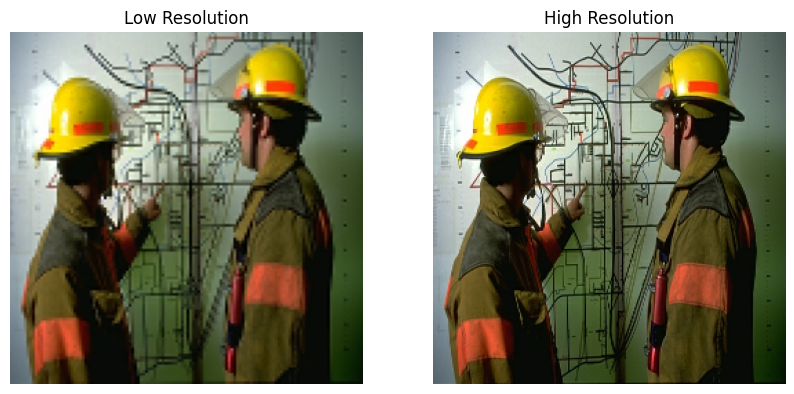

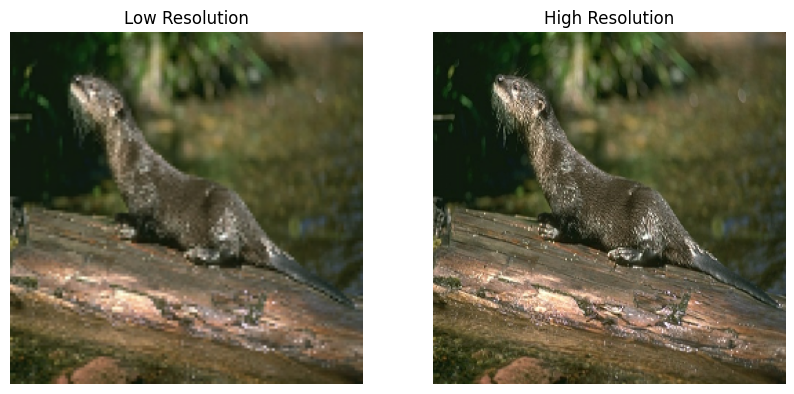

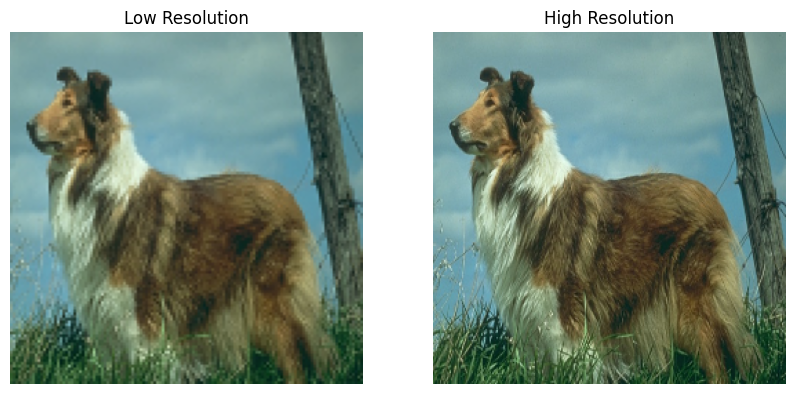

In [ ]:
# Define hyperparameters
BATCH_SIZE = 16
HR_PATCH_SIZE = IMG_HEIGHT  # 96
LR_SCALE = SCALE_FACTOR    # 4

# Create datasets
train_dataset = create_dataset(
    directory=TRAIN_DIR,
    batch_size=BATCH_SIZE,
    augment_data=False  # Enable augmentation for training
)

val_dataset = create_dataset(
    directory=VALIDATION_DIR,
    batch_size=BATCH_SIZE,
    augment_data=False  # Disable augmentation for validation
)

test_dataset = create_dataset(
    directory=TEST_DIR,
    batch_size=BATCH_SIZE,
    augment_data=False  # Disable augmentation for testing
)

# Verify the datasets by iterating through a batch
for lr_batch, hr_batch in train_dataset.take(1):
    print(f"LR batch shape: {lr_batch.shape}")  # Expected: (16, 24, 24, 3)
    print(f"HR batch shape: {hr_batch.shape}")  # Expected: (16, 96, 96, 3)")

    # Visualize the first 3 images in the batch
    for i in range(3):
        lr_img = (lr_batch[i].numpy() + 1.0) * 127.5
        lr_img = np.clip(lr_img, 0, 255).astype(np.uint8)

        hr_img = (hr_batch[i].numpy() + 1.0) * 127.5
        hr_img = np.clip(hr_img, 0, 255).astype(np.uint8)

        plt.figure(figsize=(10,5))

        plt.subplot(1,2,1)
        plt.title('Low Resolution')
        plt.imshow(lr_img)
        plt.axis('off')

        plt.subplot(1,2,2)
        plt.title('High Resolution')
        plt.imshow(hr_img)
        plt.axis('off')

        plt.show()

#Define the Generator
-residual blocks and upsampling layers to convert low-resolution images to high-resolution images.

-A residual block helps in training deeper networks by allowing gradients to flow through skip connections.

In [ ]:
def residual_block(inputs, filters, kernel_size=3, stride=1, activation='relu'):
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    return layers.Add()([inputs, x])

#Upsampling Block
Uses PixelShuffle (sub-pixel convolution) to upscale the image.


In [ ]:
def upsample_block(inputs, filters, kernel_size=3, stride=1):
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(inputs)
    x = layers.UpSampling2D()(x)
    x = layers.Activation('relu')(x)
    return x

#Generator Model

In [ ]:
def build_generator(hr_shape=(None, None, 3), num_residual_blocks=16, scale_factor=4):
    inputs = layers.Input(shape=hr_shape)

    # Initial convolution
    x = layers.Conv2D(64, 9, padding='same')(inputs)
    x = layers.Activation('relu')(x)
    residual = x

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, 64)

    # Post-residual block
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([residual, x])

    # Upsampling blocks
    for _ in range(int(tf.math.log(float(scale_factor)) / tf.math.log(2.0))):
        x = upsample_block(x, 256)

    # Final convolution
    x = layers.Conv2D(3, 9, padding='same')(x)
    outputs = layers.Activation('tanh')(x)

    model = models.Model(inputs, outputs, name='Generator')
    return model

#Define the Discriminator
The discriminator is a CNN that classifies images as real or fake.

In [ ]:
def build_discriminator(hr_shape=(None, None, 3)):
    inputs = layers.Input(shape=hr_shape)

    x = layers.Conv2D(64, 3, strides=1, padding='same')(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(64, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(128, 3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(128, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(256, 3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(256, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(512, 3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(512, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1024)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs, name='Discriminator')
    return model

#Setting Up Loss Functions
SRGAN uses a combination of adversarial loss and content loss (usually based on VGG feature maps). For simplicity, we'll implement adversarial and mean squared error (MSE) losses.

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_adversarial_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def content_loss(hr_image, generated_image):
    return tf.reduce_mean(tf.square(hr_image - generated_image))

def generator_total_loss(hr_image, generated_image, fake_output, content_weight=1e-3):
    adv_loss = generator_adversarial_loss(fake_output)
    cont_loss = content_loss(hr_image, generated_image)
    total_gen_loss = adv_loss + content_weight * cont_loss
    return total_gen_loss

##Compiling and Training the Models

# Instantiate Models and Optimizers

In [ ]:
hr_shape = (IMG_HEIGHT, IMG_WIDTH, CHANNELS)
lr_shape = (IMG_HEIGHT // SCALE_FACTOR, IMG_WIDTH // SCALE_FACTOR, CHANNELS)

# Build models
generator = build_generator(hr_shape=lr_shape, num_residual_blocks=16, scale_factor=SCALE_FACTOR)
discriminator = build_discriminator(hr_shape=hr_shape)

# Define optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.9)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


#Checkpointing

In [ ]:
checkpoint_dir = './checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

#Training Step
Define a single training step using @tf.function for performance optimization.

In [ ]:
@tf.function
def train_step(lr_images, hr_images):
    with tf.GradientTape(persistent=True) as tape:
        # Generate high-resolution images from low-resolution inputs
        generated_images = generator(lr_images, training=True)

        # Discriminator output
        real_output = discriminator(hr_images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Calculate losses
        disc_loss = discriminator_loss(real_output, fake_output)
        gen_loss = generator_total_loss(hr_images, generated_images, fake_output)

    # Calculate gradients
    gradients_of_generator = tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return disc_loss, gen_loss

#Training Loop

In [ ]:
import time

EPOCHS = 20
BATCH_SIZE = 16



for epoch in range(EPOCHS):
    start = time.time()
    total_disc_loss = 0
    total_gen_loss = 0
    num_batches = 0

    for lr, hr in train_dataset:
        disc_loss, gen_loss = train_step(lr, hr)
        total_disc_loss += disc_loss
        total_gen_loss += gen_loss
        num_batches += 1

    # Save the model every 10 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

    print(f'Epoch {epoch+1}, '
          f'Discriminator Loss: {total_disc_loss / num_batches:.4f}, '
          f'Generator Loss: {total_gen_loss / num_batches:.4f}, '
          f'Time: {time.time() - start:.2f} sec')

Epoch 1, Discriminator Loss: 2.8953, Generator Loss: 7.5099, Time: 202.57 sec
Epoch 2, Discriminator Loss: 0.0046, Generator Loss: 13.0129, Time: 132.21 sec
Epoch 3, Discriminator Loss: 0.0159, Generator Loss: 9.0180, Time: 132.10 sec
Epoch 4, Discriminator Loss: 0.2306, Generator Loss: 12.5644, Time: 131.96 sec
Epoch 5, Discriminator Loss: 1.1342, Generator Loss: 9.9760, Time: 131.65 sec
Epoch 6, Discriminator Loss: 0.6556, Generator Loss: 11.5520, Time: 131.05 sec
Epoch 7, Discriminator Loss: 1.5272, Generator Loss: 14.0314, Time: 131.16 sec
Epoch 8, Discriminator Loss: 0.5774, Generator Loss: 14.9205, Time: 131.23 sec
Epoch 9, Discriminator Loss: 0.5099, Generator Loss: 12.0520, Time: 131.00 sec
Epoch 10, Discriminator Loss: 0.5059, Generator Loss: 19.6695, Time: 148.44 sec
Epoch 11, Discriminator Loss: 0.1768, Generator Loss: 15.8962, Time: 131.36 sec
Epoch 12, Discriminator Loss: 0.5973, Generator Loss: 14.4023, Time: 130.94 sec
Epoch 13, Discriminator Loss: 0.5577, Generator Loss